<a href="https://colab.research.google.com/github/Yash-Jumde/Colab-Notebooks/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import tensorflow as tf

# Impotant functions for this notebook

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


# Plot the validation and training data separately
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


def compare_historys(original_history, new_history, initial_epochs=5):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()


Downloading a test-dataset

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-05-31 16:22:38--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2024-05-31 16:22:39 (95.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffling the dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The test data doesn't have a target

In [ ]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [ ]:
# Total samples
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Training samples: 7613
Test samples: 3263
Total samples: 10876


In [ ]:
# A random training example
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "real disaster" if target > 0 else "not a real disaster")
  print(f"Text:\n{text}\n")
  print("-------------------------------------------------\n")

Target: 1 real disaster
Text:
The Opposite of Love is Fear HereÛªs Why
http://t.co/r5bXZzhXkm

-------------------------------------------------

Target: 0 not a real disaster
Text:
U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... http://t.co/6LoJOoROuk via @Change

-------------------------------------------------

Target: 0 not a real disaster
Text:
ESN :  Cilla Black died of stroke after fall in Spain: Sir Cliff revealed he was due to visit her in Spain nextÛ_ http://t.co/F7a66dIiYK

-------------------------------------------------

Target: 0 not a real disaster
Text:
Texas Seeks Comment on Rules for Changes to Windstorm Insurer http://t.co/XQIadG9H2w http://t.co/yPEElMjdZY

-------------------------------------------------

Target: 0 not a real disaster
Text:
@ArianaGrande @justinbieber I'M SCREAMING OMG #IDOLS #22DAYS #WDYM

-------------------------------------------------



Splitting the data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size = 0.1,
    random_state = 42
)

In [ ]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

Converting the text into numbers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Default variables
text_vector = TextVectorization(max_tokens=None,
                                standardize="lower_and_strip_punctuation",
                                split="whitespace",
                                ngrams=None,
                                output_mode="int",
                                output_sequence_length=None)

In [ ]:
# Average number of tokens in training tweets
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

In [ ]:
max_vocab_length = 10000

# Using the obtained values for text_vector
text_vector = TextVectorization(max_tokens=max_vocab_length,
                                output_mode='int',
                                output_sequence_length=max_length)

In [ ]:
# Fitting the text vector
text_vector.adapt(train_sentences)

In [ ]:
# sample sentence and it's vectorization
sample_sentence = "There's a flood in my street!!"
text_vector([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

There are 0's at the end as we have set the output_sequence_length to 15, it always returns a sequence with a length of 15.

In [ ]:
random_sentence = random.choice(train_sentences)
print(f"original text:\n{random_sentence}\
      \nVectorized version: {text_vector([random_sentence])}")

original text:
And you wonder why he's injured every year https://t.co/XYiwR9JETl      
Vectorized version: [[  7  12 914  91 277 243 197 183   1   0   0   0   0   0   0]]


In [ ]:
# Getting the unique words in the vocabulary

words_in_vocab = text_vector.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

print(f"Number of words in vocab {len(words_in_vocab)}")
print(f"Top 5 words: {top_5_words}")
print(f"bottom 5 words: {bottom_5_words}")

Number of words in vocab 10000
Top 5 words: ['', '[UNK]', 'the', 'a', 'in']
bottom 5 words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


Creating an embedding.

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name='embedding')

embedding

In [ ]:
# For a random sample sentence
random_sentence = random.choice(train_sentences)
sample_embedded = embedding(text_vector([random_sentence]))
print(f"Original text\n{random_sentence}")
print(f"Embedded version: {sample_embedded}")

Original text
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...
Embedded version: [[[-0.03606399  0.03726501 -0.04126992 ... -0.02396358 -0.01014094
   -0.0210322 ]
  [ 0.04261191  0.02363369 -0.00240725 ...  0.0016214  -0.03384399
    0.01010474]
  [ 0.03238045 -0.03783341 -0.03077282 ...  0.02339644 -0.00627013
   -0.03527824]
  ...
  [ 0.04363662 -0.01847632  0.04629991 ... -0.0256001   0.02222707
    0.02165016]
  [ 0.03238045 -0.03783341 -0.03077282 ...  0.02339644 -0.00627013
   -0.03527824]
  [ 0.02413063 -0.04286787  0.02837601 ...  0.03486643 -0.03888754
    0.02304674]]]


In [ ]:
sample_embedded

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03606399,  0.03726501, -0.04126992, ..., -0.02396358,
         -0.01014094, -0.0210322 ],
        [ 0.04261191,  0.02363369, -0.00240725, ...,  0.0016214 ,
         -0.03384399,  0.01010474],
        [ 0.03238045, -0.03783341, -0.03077282, ...,  0.02339644,
         -0.00627013, -0.03527824],
        ...,
        [ 0.04363662, -0.01847632,  0.04629991, ..., -0.0256001 ,
          0.02222707,  0.02165016],
        [ 0.03238045, -0.03783341, -0.03077282, ...,  0.02339644,
         -0.00627013, -0.03527824],
        [ 0.02413063, -0.04286787,  0.02837601, ...,  0.03486643,
         -0.03888754,  0.02304674]]], dtype=float32)>

Modelling a text dataset

Model 0 : getting a baseline (Naive Bayes)

Here we are creating a Scikit-Learn pipeline using the TF-IDF (term frequency - inverse document frequency) to convert our words to numbers and then model them with the **Multinomial Naive Bayes algorithm**.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model accuracy: {baseline_score*100:.2f}%")

Baseline model accuracy: 79.27%


In [ ]:
# Predictions
baseline_predictions = model_0.predict(val_sentences)
baseline_predictions[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Function to evaluate: accuraacy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # Accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_predictions)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Model 1: Dense Model

Here we will take the text and labels as input, tokenize the text, create an embedding, find the average of the embedding and then pass it through a fully connected layer with one output unit and a sigmoid activation function.

In [ ]:
# For tensorboard callback
SAVE_DIR = "model_logs"

In [ ]:
# model build
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])


Saving TensorBoard log files to: model_logs/simple_dense_model/20240531-162243
Epoch 1/5
215/215 [==============================] - 10s 38ms/step - loss: 0.6102 - accuracy: 0.6923 - val_loss: 0.5363 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 9s 41ms/step - loss: 0.4416 - accuracy: 0.8186 - val_loss: 0.4691 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 9s 43ms/step - loss: 0.3467 - accuracy: 0.8616 - val_loss: 0.4589 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.2852 - accuracy: 0.8920 - val_loss: 0.4639 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 7s 33ms/step - loss: 0.2383 - accuracy: 0.9120 - val_loss: 0.4765 - val_accuracy: 0.7861


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 8ms/step - loss: 0.4765 - accuracy: 0.7861


[0.47648879885673523, 0.7860892415046692]

In [ ]:
embedding.weights

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.02126333, -0.05939592,  0.01058103, ...,  0.0523469 ,
         -0.05935701, -0.01589711],
        [-0.04461236, -0.01971451,  0.00950363, ..., -0.00860245,
          0.03613629,  0.02784519],
        [-0.00734588, -0.00890475,  0.00602275, ...,  0.02742474,
         -0.03689394, -0.03179537],
        ...,
        [ 0.01241798, -0.00413041,  0.02427259, ..., -0.0222441 ,
          0.02089028,  0.03771528],
        [ 0.00446764, -0.01938926, -0.00573905, ...,  0.04745048,
         -0.02234251,  0.03179605],
        [-0.07668966, -0.02601667, -0.0675623 , ...,  0.02236539,
         -0.1050891 ,  0.0875928 ]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# Model 1 Predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.4284711 ],
       [0.74536425],
       [0.99779433],
       [0.11161364],
       [0.10884041],
       [0.93603384],
       [0.9123807 ],
       [0.9928988 ],
       [0.9690309 ],
       [0.26502284]], dtype=float32)

In [ ]:
# Turning the prediction probabilities into single-dimension tensors
# If probability < 0.5 round it 0; if probability > 0.5 round it to 1
model_1_predictions = tf.squeeze(tf.round(model_1_pred_probs))
model_1_predictions[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
model_1_results = calculate_results(y_true=val_labels,
                               y_pred=model_1_predictions)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [ ]:
# Function to compare baseline results to new model

def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, new {key}: {new_model_results[key]:.2f}")
    print(f"Difference: {new_model_results[key]-value:.2f}")


In [ ]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, new accuracy: 78.61
Difference: -0.66
Baseline precision: 0.81, new precision: 0.79
Difference: -0.02
Baseline recall: 0.79, new recall: 0.79
Difference: -0.01
Baseline f1: 0.79, new f1: 0.78
Difference: -0.00


Recurrent Neural Networks (RNNs)

Model 2: **LSTM**

In [ ]:
# New embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20240531-162329
Epoch 1/5
215/215 [==============================] - 20s 67ms/step - loss: 0.5156 - accuracy: 0.7424 - val_loss: 0.4553 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 11s 52ms/step - loss: 0.3210 - accuracy: 0.8721 - val_loss: 0.5105 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 10s 48ms/step - loss: 0.2217 - accuracy: 0.9130 - val_loss: 0.5736 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 10s 47ms/step - loss: 0.1537 - accuracy: 0.9442 - val_loss: 0.7203 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 0.1077 - accuracy: 0.9584 - val_loss: 0.8368 - val_accuracy: 0.7730


In [ ]:
model_2_prediction_probs = model_2.predict(val_sentences)
model_2_prediction_probs.shape, model_2_prediction_probs[:10]

24/24 [==============================] - 1s 8ms/step


((762, 1),
 array([[0.00631997],
        [0.72958905],
        [0.9986843 ],
        [0.03336703],
        [0.0010609 ],
        [0.9975324 ],
        [0.8381414 ],
        [0.99937874],
        [0.9983522 ],
        [0.41596147]], dtype=float32))

In [ ]:
# Round out the predictions
model_2_predictions = tf.squeeze(tf.round(model_2_prediction_probs))
model_2_predictions[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_predictions)
model_2_results

{'accuracy': 77.29658792650919,
 'precision': 0.775649278370019,
 'recall': 0.7729658792650919,
 'f1': 0.7704381702262061}

In [ ]:
# Comparing with baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, new accuracy: 77.30
Difference: -1.97
Baseline precision: 0.81, new precision: 0.78
Difference: -0.04
Baseline recall: 0.79, new recall: 0.77
Difference: -0.02
Baseline f1: 0.79, new f1: 0.77
Difference: -0.02


Model 3: **GRU**

In [ ]:
tf.random.set_seed(42)

from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
# To stack recurent cells: x = layers.GRU(64, return_sequences=True)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

In [ ]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240531-162433
Epoch 1/5
215/215 [==============================] - 16s 48ms/step - loss: 0.5397 - accuracy: 0.7171 - val_loss: 0.4501 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 11s 51ms/step - loss: 0.3263 - accuracy: 0.8653 - val_loss: 0.4904 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 10s 48ms/step - loss: 0.2216 - accuracy: 0.9165 - val_loss: 0.5460 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 9s 42ms/step - loss: 0.1568 - accuracy: 0.9435 - val_loss: 0.6362 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 10s 46ms/step - loss: 0.1148 - accuracy: 0.9602 - val_loss: 0.6180 - val_accuracy: 0.7677


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


((762, 1),
 array([[0.24704391],
        [0.9064677 ],
        [0.9988725 ],
        [0.16311865],
        [0.01520122],
        [0.99527264],
        [0.8129676 ],
        [0.9980156 ],
        [0.99829376],
        [0.52608824]], dtype=float32))

In [ ]:
# Rounding off the probs
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7674148766835972,
 'recall': 0.7677165354330708,
 'f1': 0.7669760007914206}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, new accuracy: 76.77
Difference: -2.49
Baseline precision: 0.81, new precision: 0.77
Difference: -0.04
Baseline recall: 0.79, new recall: 0.77
Difference: -0.02
Baseline f1: 0.79, new f1: 0.77
Difference: -0.02


Bidirectional RNN model

A Bidirectional RNN will process the sequence from left to right and then again from right to left.

In [ ]:
tf.random.set_seed(42)

from tensorflow.keras import layers

model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Bidirectional RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_classification")

In [ ]:
# Compiling
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable pa

In [ ]:
# Fitting the model
modeL_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectionaal_RNN")])
# Due to added parameters there will be slight increase in training time

Saving TensorBoard log files to: model_logs/bidirectionaal_RNN/20240531-162533
Epoch 1/5
215/215 [==============================] - 24s 70ms/step - loss: 0.5106 - accuracy: 0.7434 - val_loss: 0.4563 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 14s 65ms/step - loss: 0.3135 - accuracy: 0.8729 - val_loss: 0.5199 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 15s 69ms/step - loss: 0.2134 - accuracy: 0.9175 - val_loss: 0.5631 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 14s 66ms/step - loss: 0.1454 - accuracy: 0.9520 - val_loss: 0.6532 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 14s 63ms/step - loss: 0.1044 - accuracy: 0.9647 - val_loss: 0.7132 - val_accuracy: 0.7598


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[0.02662836],
       [0.8923988 ],
       [0.9994867 ],
       [0.15009446],
       [0.00368539],
       [0.99849975],
       [0.98443735],
       [0.99962115],
       [0.9996664 ],
       [0.2649748 ]], dtype=float32)

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.98425196850394,
 'precision': 0.7594292639037933,
 'recall': 0.7598425196850394,
 'f1': 0.759413131725221}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, new accuracy: 75.98
Difference: -3.28
Baseline precision: 0.81, new precision: 0.76
Difference: -0.05
Baseline recall: 0.79, new recall: 0.76
Difference: -0.03
Baseline f1: 0.79, new f1: 0.76
Difference: -0.03


Model 5 : Convolutional Neural Network (1D)

In [ ]:
# Testing different output shapes.
embedding_test = embedding(text_vector(["This is a sample sentence"]))
# Conv1D layer
# 5 words at a time
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu")
conv_1d_output = conv_1d(embedding_test)
# Pooling layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

# output shapes
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.05187386,  0.00576202, -0.00225579, ..., -0.00528893,
           0.00366609, -0.02383389],
         [-0.08571203, -0.01778687, -0.08587623, ...,  0.06646295,
          -0.07034741,  0.0769686 ],
         [ 0.02058846, -0.03130295, -0.01406014, ...,  0.0074313 ,
          -0.00300904,  0.00159104],
         ...,
         [-0.02126333, -0.05939592,  0.01058103, ...,  0.0523469 ,
          -0.05935701, -0.01589711],
         [-0.02126333, -0.05939592,  0.01058103, ...,  0.0523469 ,
          -0.05935701, -0.01589711],
         [-0.02126333, -0.05939592,  0.01058103, ...,  0.0523469 ,
          -0.05935701, -0.01589711]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.04449339, 0.03706323, 0.        , 0.        ,
          0.        , 0.        , 0.03271007, 0.        , 0.        ,
          0.        , 0.06825605, 0.        , 0.02615997, 0.        ,
          0.        , 0.

In [ ]:
# The conv1D model

tf.random.set_seed(42)
from tensorflow.keras import layers

# Embedding text
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# 1D cnn model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vector(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [ ]:
model_5.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 64)             

In [ ]:
# Fitting the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240531-162706
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.5498 - accuracy: 0.7193 - val_loss: 0.4592 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.3125 - accuracy: 0.8765 - val_loss: 0.4909 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1678 - accuracy: 0.9421 - val_loss: 0.5379 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1031 - accuracy: 0.9689 - val_loss: 0.6093 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0756 - accuracy: 0.9772 - val_loss: 0.6204 - val_accuracy: 0.7677


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs

24/24 [==============================] - 0s 2ms/step


array([[4.00939733e-01],
       [7.60617673e-01],
       [9.98884201e-01],
       [4.85055633e-02],
       [1.64269079e-02],
       [9.96455729e-01],
       [7.53840029e-01],
       [9.94625568e-01],
       [9.97494996e-01],
       [2.14875460e-01],
       [1.94769762e-02],
       [2.49207556e-01],
       [1.41505580e-02],
       [9.77111980e-02],
       [1.80472911e-03],
       [1.85873732e-02],
       [8.15891009e-03],
       [4.66666184e-02],
       [1.04242109e-01],
       [4.91656184e-01],
       [6.67426348e-01],
       [7.77892442e-03],
       [5.88107049e-01],
       [1.57173220e-02],
       [9.89477575e-01],
       [9.99624074e-01],
       [6.12458400e-03],
       [1.32033257e-02],
       [1.55742578e-02],
       [2.69270718e-01],
       [3.18174422e-01],
       [2.80076683e-01],
       [6.48682892e-01],
       [1.71141803e-01],
       [3.91026914e-01],
       [7.79359818e-01],
       [9.99940336e-01],
       [2.43665293e-01],
       [8.72942992e-03],
       [9.98537719e-01],


In [ ]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [ ]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 76.77165354330708,
 'precision': 0.7705418629507439,
 'recall': 0.7677165354330708,
 'f1': 0.7649853724238768}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, new accuracy: 76.77
Difference: -2.49
Baseline precision: 0.81, new precision: 0.77
Difference: -0.04
Baseline recall: 0.79, new recall: 0.77
Difference: -0.02
Baseline f1: 0.79, new f1: 0.76
Difference: -0.02


Using Pretrained Embeddings ==> Transfer Learning for NLP

Model 6 : Tensorflow Hub Pretrained Sentence Encoder

Here we are using the universal sentence encoder, which creates a sentence level embedding as comparto our word level. This encoder outputs a 512 dimensional vector for each sentence.

In [ ]:
# Loading the Universal sentence encoder.
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, sample_sentence+sample_sentence])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")
# We will use this layer in place of the text_vetor and the embedding layer

In [ ]:
# Creating the model

model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


Here as the trainable parameters are only in the output layers, the weights for the USE are frozen. This means we are feature extracting and not fine-tuning the layer to our dataset.

In [ ]:
# training the model

model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_USE")])

In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8155610053499988,
 'recall': 0.8123359580052494,
 'f1': 0.8104722790014789}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, new accuracy: 81.23
Difference: 1.97
Baseline precision: 0.81, new precision: 0.82
Difference: 0.00
Baseline recall: 0.79, new recall: 0.81
Difference: 0.02
Baseline f1: 0.79, new f1: 0.81
Difference: 0.02


Model 7 : Train the previous model on 10% of the training data.

In [ ]:
# splitting the already split data
import numpy as np
train_sentences_90, train_sentences_10, train_labels_90, train_labels_10 = train_test_split(
    np.array(train_sentences),
    train_labels,
    test_size=0.1,
    random_state=42
)

In [ ]:
len(train_sentences), len(train_sentences_10)

(6851, 686)

In [ ]:
# Checking the number of targets in our subset data
pd.Series(train_labels_10).value_counts()

0    415
1    271
Name: count, dtype: int64

In [ ]:
# We are using the same model as model 6. Thus,
model_7 = tf.keras.models.clone_model(model_6)

# Compile
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_7_history = model_7.fit(train_sentences_10,
                              train_labels_10,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_USE")])


Saving TensorBoard log files to: model_logs/10_percent_USE/20240531-163827
Epoch 1/5
22/22 [==============================] - 16s 115ms/step - loss: 0.6707 - accuracy: 0.6676 - val_loss: 0.6569 - val_accuracy: 0.6535
Epoch 2/5
22/22 [==============================] - 2s 87ms/step - loss: 0.6036 - accuracy: 0.7901 - val_loss: 0.6050 - val_accuracy: 0.7257
Epoch 3/5
22/22 [==============================] - 2s 93ms/step - loss: 0.5272 - accuracy: 0.8207 - val_loss: 0.5506 - val_accuracy: 0.7533
Epoch 4/5
22/22 [==============================] - 1s 62ms/step - loss: 0.4599 - accuracy: 0.8367 - val_loss: 0.5144 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 1s 56ms/step - loss: 0.4142 - accuracy: 0.8426 - val_loss: 0.4954 - val_accuracy: 0.7756


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

In [ ]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

In [ ]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Comparing all the models

In [ ]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1D": model_5_results,
                                  "USE": model_6_results,
                                  "USE_10_percent": model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
# Plot and compare all of the models results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0,1.0))

In [ ]:
# Sort models results by  f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

Combining the models (Model Stacking)

Here, the idea is that if several uncorrelated models have the same prediction, then the prediction must be more robust.

We can do this by:
1. Averaging
2. Mode
3. Model stacking --> outputs of a model are used as an input for another model.

In [ ]:
# Mean pred probs for the three models.
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis = 1)
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_prediction_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
combined_results = calculate_results(val_labels, combined_preds)
combined_results

{'accuracy': 78.60892388451444,
 'precision': 0.7860116675698938,
 'recall': 0.7860892388451444,
 'f1': 0.7853246889177204}

In [ ]:
# adding it to all model results
all_model_results.loc["combined_results"] = combined_results

In [ ]:
all_model_results["accuracy"]["combined_results"] = all_model_results["accuracy"]["combined_results"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.763780,0.765730,0.763780,0.761364
gru,0.770341,0.770121,0.770341,0.769520
bidirectional,0.775591,0.776962,0.775591,0.773741
conv1D,0.784777,0.789165,0.784777,0.781896
USE,0.812336,0.815561,0.812336,0.810472
USE_10_percent,0.775591,0.780205,0.775591,0.772357
combined_results,0.786089,0.786012,0.786089,0.785325


Finding the most wrong examples

In [ ]:
validation_df = pd.DataFrame({"text": val_sentences,
                              "target": val_labels,
                              "pred": model_6_preds,
                              "pred_prob": tf.squeeze(model_6_pred_probs)})

validation_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159011
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.750847
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.991741
3,@camilacabello97 Internally and externally scr...,1,0.0,0.210068
4,Radiation emergency #preparedness starts with ...,1,1.0,0.702734


In [ ]:
# Finding the wrong predictions
most_wrong = validation_df[validation_df["target"] != validation_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.920183
628,@noah_anyname That's where the concentration c...,0,1.0,0.876362
759,FedEx will no longer transport bioterror patho...,0,1.0,0.873009
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.843644
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.827578
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.816337
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.810571
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.810393
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.770595
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.767385


In [ ]:
# Checking for false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n {text}\n\n")

Target: 0, Pred: 1, Prob: 0.9201827049255371
Text:
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying


Target: 0, Pred: 1, Prob: 0.8763617277145386
Text:
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.


Target: 0, Pred: 1, Prob: 0.873009443283081
Text:
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J


Target: 0, Pred: 1, Prob: 0.8436436653137207
Text:
 @SonofLiberty357 all illuminated by the brightly burning buildings all around the town!


Target: 0, Pred: 1, Prob: 0.8275781273841858
Text:
 @madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods


Target: 0, Pred: 1, Prob: 0.8163366317749023
Text:
 [55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY


Target: 0, Pred: 1, Prob: 0.8105711936950684
Text:
 @AshGhebra

In [ ]:
# Checking false negatives.
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n {text}\n\n")

Target: 1, Pred: 0, Prob: 0.06213303655385971
Text:
 'The way you move is like a full on rainstorm and I'm a house of cards'


Target: 1, Pred: 0, Prob: 0.06186872348189354
Text:
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets


Target: 1, Pred: 0, Prob: 0.0575287900865078
Text:
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy


Target: 1, Pred: 0, Prob: 0.05257507786154747
Text:
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu


Target: 1, Pred: 0, Prob: 0.048620495945215225
Text:
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.


Target: 1, Pred: 0, Prob: 0.04748659208416939
Text:
 Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy


Target: 1, Pred: 0, Prob: 

In [ ]:
# Function for predictions on some tweets found.
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "real disaster" if pred_label > 0 else "not a real disaster", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n {sentence}")

In [ ]:
tweet_1 = "Life like an ensemble: take the best choices from others and make your own"
tweet_2 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"
tweet_3 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [ ]:
predict_on_sentence(model_6, tweet_1)

1/1 [==============================] - 0s 229ms/step
Pred: 0.0 not a real disaster Prob: 0.057273052632808685
Text:
 Life like an ensemble: take the best choices from others and make your own


In [ ]:
predict_on_sentence(model_6, tweet_2)

1/1 [==============================] - 0s 218ms/step
Pred: 1.0 real disaster Prob: 0.9705180525779724
Text:
 Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [ ]:
predict_on_sentence(model_6, tweet_3)

1/1 [==============================] - 0s 123ms/step
Pred: 1.0 real disaster Prob: 0.9732449650764465
Text:
 #Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


Speed/score tradeoff

In [ ]:
import time
# Function to calculate how much time a model takes to predict
def pred_time(model, samples):
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# For model 6
model_6_pred_time, model_6_time_per_pred = pred_time(model_6, val_sentences)
model_6_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 14ms/step


(0.7223347069998454, 0.0009479458097110832)

In [ ]:
# for model 0
baseline_pred_time, baseline_time_per_pred = pred_time(model_0, val_sentences)
baseline_pred_time, baseline_time_per_pred

(0.09248276400012401, 0.00012136845669307612)

Text(0, 0.5, 'F1-score')

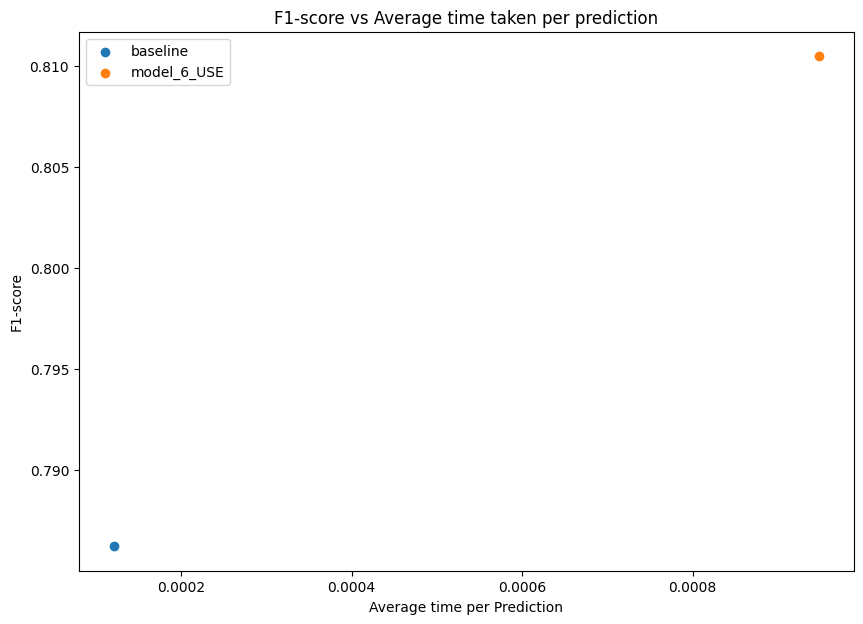

In [ ]:
# comparing the f1 scores for these two models

import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="model_6_USE")
plt.legend()
plt.title("F1-score vs Average time taken per prediction")
plt.xlabel("Average time per Prediction")
plt.ylabel("F1-score")